## Загрузка

In [ ]:
import importlib.util, sys, gdown

In [ ]:
url = 'https://storage.googleapis.com/aiu_bucket/data.zip'
output = 'data.zip' # Указываем имя файла, в который сохраняем файл
gdown.download(url, output, quiet=True) # Скачиваем файл по указанному URL

'data.zip'

In [ ]:
!unzip -q data.zip -d ''

## Основной блок

In [ ]:
import utils # Подключаем набор функций

**Загрузка данных**

In [ ]:
train_dataset, val_dataset = utils.getData() # Загружаем обучающий и проверочный датасет

In [ ]:
utils.show_data(train_dataset, start=0, end=0, param=['Close','High','Low','Open']) # Визуализируем обучающий датасет

In [ ]:
utils.show_full_data(train_dataset, val_dataset,param=['Close','High','Low','Open'])

**Блок создания нейронной сети**

In [ ]:
# Подготовка данных - scaling
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from matplotlib import pyplot

sc = MinMaxScaler(feature_range=(0, 1))

train_dataset_Close = pd.DataFrame(train_dataset['Close'])
train_dataset_Close_scaled = sc.fit_transform(train_dataset_Close)
train_dataset_Close_scaled.shape

(2700, 1)

In [ ]:
X_train = []
Y_train = []

window_size = 7

for i in range(window_size,2700):
  X_train.append(train_dataset_Close_scaled[i-window_size:i,0])
  Y_train.append(train_dataset_Close_scaled[i,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2693, 7, 1)

In [ ]:
model = Sequential()

model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
 
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
 
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
 
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer = 'adam')

In [ ]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=300, verbose=2)

Epoch 1/300
85/85 - 5s - loss: 0.0062
Epoch 2/300
85/85 - 1s - loss: 9.0896e-04
Epoch 3/300
85/85 - 1s - loss: 7.8146e-04
Epoch 4/300
85/85 - 1s - loss: 8.3488e-04
Epoch 5/300
85/85 - 1s - loss: 0.0010
Epoch 6/300
85/85 - 1s - loss: 6.5257e-04
Epoch 7/300
85/85 - 1s - loss: 7.6106e-04
Epoch 8/300
85/85 - 1s - loss: 7.2205e-04
Epoch 9/300
85/85 - 1s - loss: 6.8714e-04
Epoch 10/300
85/85 - 1s - loss: 7.7392e-04
Epoch 11/300
85/85 - 1s - loss: 7.1468e-04
Epoch 12/300
85/85 - 1s - loss: 6.8656e-04
Epoch 13/300
85/85 - 1s - loss: 6.9522e-04
Epoch 14/300
85/85 - 1s - loss: 7.0033e-04
Epoch 15/300
85/85 - 1s - loss: 7.2319e-04
Epoch 16/300
85/85 - 1s - loss: 6.0847e-04
Epoch 17/300
85/85 - 1s - loss: 5.1036e-04
Epoch 18/300
85/85 - 1s - loss: 6.6726e-04
Epoch 19/300
85/85 - 1s - loss: 5.6133e-04
Epoch 20/300
85/85 - 1s - loss: 5.9037e-04
Epoch 21/300
85/85 - 1s - loss: 6.9421e-04
Epoch 22/300
85/85 - 1s - loss: 6.3238e-04
Epoch 23/300
85/85 - 1s - loss: 5.2463e-04
Epoch 24/300
85/85 - 1s - lo

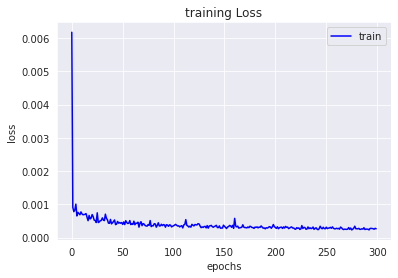

In [ ]:
pyplot.plot(history.history['loss'], color='blue')
pyplot.title('training Loss')
pyplot.ylabel('loss')
pyplot.xlabel('epochs')
pyplot.legend(['train'], loc='upper right')
pyplot.show()

In [ ]:
val_dataset_Close = pd.DataFrame(val_dataset['Close'])
val_dataset_Close_scaled = sc.fit_transform(val_dataset_Close)
val_dataset_Close_scaled.shape

(300, 1)

In [ ]:
X_val = []
Y_val = val_dataset_Close.iloc[window_size:, 0:].values
for i in range(window_size,300):
  X_val.append(val_dataset_Close_scaled[i-window_size:i,0])

X_val = np.array(X_val)

X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))


In [ ]:
Y_pred = model.predict(X_val)
predicted_Close = sc.inverse_transform(Y_pred)

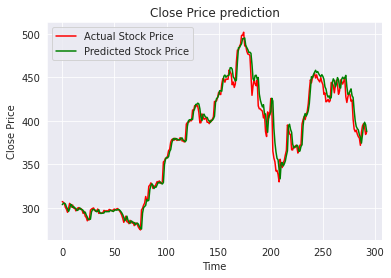

In [ ]:
# 7
pyplot.plot(Y_val, color='red', label='Actual Stock Price')
pyplot.plot(predicted_Close, color='green', label='Predicted Stock Price')
pyplot.title('Close Price prediction')
pyplot.ylabel('Close Price')
pyplot.xlabel('Time')
pyplot.legend(loc='upper left')
pyplot.show()

**Блок тестирования модели**

In [ ]:
# стратегия

def trend(df):
  if df.iloc[df.shape[0]-2]['Close'] > df.iloc[df.shape[0]-4]['Close'] and df.iloc[df.shape[0]-3]['Close'] > df.iloc[df.shape[0]-5]['Close'] :
    return 'up'
  elif df.iloc[df.shape[0]-2]['Close'] < df.iloc[df.shape[0]-4]['Close'] and df.iloc[df.shape[0]-3]['Close'] > df.iloc[df.shape[0]-5]['Close'] :
    return 'down'
  else:
    return 'flat'


def traide(df):

  if trend(df) == 'flat':
    return 0

  if lastBuyPrice == 0:
    if trend(df) == 'up':
      return 1
    else:
      return 0

  if df.iloc[-1]['Close'] == lastBuyPrice:
    return 0
  
  if df.iloc[-1]['Close'] > lastBuyPrice:
    if trend(df) == 'up':
      return 0 
    else:
      return 2

  if df.iloc[-1]['Close'] < lastBuyPrice:
    if trend(df) == 'down':
      return 0
    else:
      return 1 
  '''
  0 - ничего не делать
  1 - покупать
  2 - продавать
  '''


In [ ]:
# Ваша стратегия
money = 100000 # Стартовый капитал
shares = 0 # Стартовое количество акций
dataset = train_dataset.append(val_dataset).reset_index() # Объединяем обучающий и проверочный датасеты
money_history = [money] # Статистика капитала

lastBuyPrice = 0

# Проходим по всему тестовому датасету
for i in range(1, test_dataset.shape[0]+1):
  df = dataset.append(test_dataset[:i]).reset_index() # Считываем очередное значение из тестового датасета
 
  if i == 1:
    action = 1
    
  action = traide(df) # Получаем действие, которое будем совершать
  # Если это последнее значение тестовой выборки
  if i == val_dataset.shape[0]:
    action = 2 # продаём все акции

  # Если должны покупать и есть деньги хотя бы на одну акцию
  if action==1 and money > df.iloc[-1]['Close']:
    shares += money // df.iloc[-1]['Close'] # Покупаем на все имеющиеся деньги акции (покупаем целое количество (не обязательно))
    money = money % df.iloc[-1]['Close'] # Считаем сколько осталось денег после покупки акций
    lastBuyPrice = df.iloc[-1]['Close']
    
    # Выводим статистическую информацию
    print('Купили')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print(trend(df))
    print('------------------------')

  # Если должны продавать
  elif action==2:
    money += shares * df.iloc[-1]['Close'] # Продаем все акции и увеличиваем капитал на заработанные деньги
    shares = 0 # Количество акцией сбрасываем в 0
    lastBuyPrice = 0
    
    # Выводим статистическую информацию
    print('Продали')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print(trend(df))
    print('------------------------')  
  elif action==0:
    
    # Выводим статистическую информацию
    print('Ждём')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print(trend(df))
    print('------------------------')  

  money_history.append(money) # Записываем в статистику капитала текущее значение имеющихся денег

# Выводим статистику изменения капитала
plt.figure(figsize=(14,7))
plt.plot(money_history)
plt.show()


In [ ]:
print('Финальный результат: ', round(money,2), 'руб.')

# Стратегия на проверочной выборке.

Ждём
Цена: 285.96063232421875
Денег: 100000
Акций: 0
flat
------------------------
Купили
Цена: 288.23602294921875
Денег: 270.3360595703125
Акций: 346.0
up
------------------------
Продали
Цена: 294.70599365234375
Денег: 102238.60986328125
Акций: 0
down
------------------------
Ждём
Цена: 299.60736083984375
Денег: 102238.60986328125
Акций: 0
flat
------------------------
Купили
Цена: 307.79998779296875
Денег: 49.013916015625
Акций: 332.0
up
------------------------
Ждём
Цена: 307.98199462890625
Денег: 49.013916015625
Акций: 332.0
up
------------------------
Ждём
Цена: 307.3999938964844
Денег: 49.013916015625
Акций: 332.0
down
------------------------
Ждём
Цена: 306.53460693359375
Денег: 49.013916015625
Акций: 332.0
flat
------------------------
Ждём
Цена: 304.8340148925781
Денег: 49.013916015625
Акций: 332.0
flat
------------------------
Ждём
Цена: 300.61199951171875
Денег: 49.013916015625
Акций: 332.0
down
------------------------
Ждём
Цена: 298.61199951171875
Денег: 49.013916015625
А

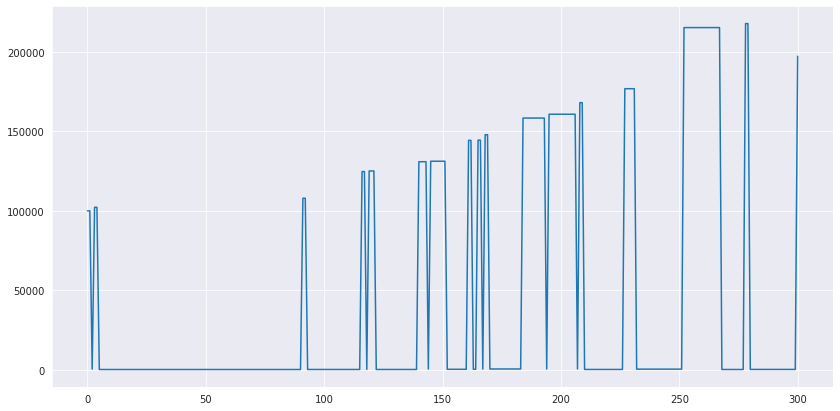

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ваша стратегия
money = 100000 # Стартовый капитал
shares = 0 # Стартовое количество акций
dataset = train_dataset # В dataset записываем обучающий набор
money_history = [money] # Статистика капитала

lastBuyPrice = 0

# Проходим по всему проверочному набору
for i in range(1, val_dataset.shape[0]+1):
  df = train_dataset.append(val_dataset[:i]).reset_index() # Считываем очередное значение из проверочного набора
  if i == 1:
    action = 1
    
  action = traide(df) # Получаем действие, которое будем совершать
  # Если это последнее значение тестовой выборки
  if i == val_dataset.shape[0]:
    action = 2 # продаём все акции

  # Если должны покупать и есть деньги хотя бы на одну акцию
  if action==1 and money > df.iloc[-1]['Close']:
    shares += money // df.iloc[-1]['Close'] # Покупаем на все имеющиеся деньги акции (покупаем целое количество (не обязательно))
    money = money % df.iloc[-1]['Close'] # Считаем сколько осталось денег после покупки акций
    lastBuyPrice = df.iloc[-1]['Close']
    
    # Выводим статистическую информацию
    print('Купили')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print(trend(df))
    print('------------------------')

  # Если должны продавать
  elif action==2:
    money += shares * df.iloc[-1]['Close'] # Продаем все акции и увеличиваем капитал на заработанные деньги
    shares = 0 # Количество акцией сбрасываем в 0
    lastBuyPrice = 0
    
    # Выводим статистическую информацию
    print('Продали')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print(trend(df))
    print('------------------------')  
  elif action==0:
    
    # Выводим статистическую информацию
    print('Ждём')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print(trend(df))
    print('------------------------')  

  money_history.append(money) # Записываем в статистику капитала текущее значение имеющихся денег

# Выводим статистику изменения капитала
plt.figure(figsize=(14,7))
plt.plot(money_history)
plt.show()


In [ ]:
print('Финальный результат: ', round(money,2), 'руб.')

Финальный результат:  197417.28 руб.
